# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import cross_validation

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite')

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be 0 and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
print(filtered_data.shape) 
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1; 

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [12]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'at', 'have', "hadn't", 'wasn', 'hasn', 'ours', 'or', 'with', 'for', 'not', 'd', 'such', 'on', 'now', 'too', 'than', 'mustn', 'before', 'yourself', 'herself', 'this', 'as', "weren't", 'above', 'under', 'haven', 'ourselves', 'are', 'll', 'only', 'off', 'yourselves', 's', 'o', 'because', 'after', "doesn't", 'of', 'the', 'to', 'myself', "shan't", 've', 'more', "hasn't", "it's", 'm', 'over', 'and', 'is', 'needn', 'we', 'in', 'a', 'its', 'been', 'why', 'wouldn', 'isn', "you'd", 'hadn', "isn't", 'between', 'his', 'again', 'own', 'be', 'further', 'up', 'don', 'all', 'into', 'here', 'their', 'won', "you'll", 'who', 'i', 'so', 'my', 'it', 'by', 'ma', 'didn', 'am', 'her', 'where', 'our', 'him', 'theirs', 'some', "should've", 'himself', 'ain', 'how', 'me', 'but', 'weren', 'does', 'once', "needn't", "wouldn't", 'while', 'having', 'whom', 'do', 'no', 'through', 'couldn', 'she', "you've", 'hers', 'yours', 'them', 'those', 'just', "you're", 'against', 'were', 'can', 'you', 'each', 'then', 'during', 

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [15]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [16]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [17]:
con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [18]:
print(cleaned_data.shape)
cleaned_data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [19]:
cleaned_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [20]:
# To randomly sample 100k points from both class

random_sample_data = final.sample(n=100000) 
random_sample_data.shape

(100000, 11)

In [21]:
# Sort data based on time
final_sorted_time=random_sample_data.sort_values('Time',ascending=True,axis=0)

In [22]:
final_sorted_time.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...
346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,1,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,b'get crazi look beatlejuic french version vid...
346115,374421,B00004CI84,A1FJOY14X3MUHE,Justin Howard,2,2,1,966297600,"A fresh, original film from master storyteller...","This is such a great film, I don't even know h...",b'great film dont even know sum first complet ...
138000,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,1,975974400,Who Needs Wilton?,I'm sick of scads of nasty toothpicks all over...,b'sick scad nasti toothpick counter tint conce...


In [23]:
final_sorted_time['Score'].value_counts()

1    84219
0    15781
Name: Score, dtype: int64

In [24]:
#data splitting
y_Train=final_sorted_time['Score'][0:70000]
y_train=final_sorted_time['Score'][0:49000]
y_cv=final_sorted_time['Score'][49000:70000]
y_test=final_sorted_time['Score'][70000:100000]

In [25]:
Train_data=final_sorted_time['CleanedText'][0:70000]
train_data=final_sorted_time['CleanedText'][0:49000]
cv_data=final_sorted_time['CleanedText'][49000:70000]
test_data=final_sorted_time['CleanedText'][70000:100000]

# [4] Featurization

## [4.1] BAG OF WORDS

In [26]:
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(train_data)
bow_cv = count_vect.transform(cv_data)
#count_vect.get_feature_names()
print(bow_train.shape)
bow_cv.shape

(49000, 27187)


(21000, 27187)

In [27]:
#taking vector of test data
count_vectorizer=CountVectorizer()
Train_bows=count_vectorizer.fit_transform(Train_data)
test_bows=count_vectorizer.transform(test_data)

## [4.2] Bi-Grams and n-Grams.

In [28]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
#taking one words and two consecutive words together
from sklearn import preprocessing
bi_gram_model = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000) 
Train_bi_gram = bi_gram_model.fit_transform(Train_data)
#Normalize Data
Train_bi_gram = preprocessing.normalize(Train_bi_gram)
print("Train Data Size: ",Train_bi_gram.shape)
test_bi_gram = bi_gram_model.transform(test_data)
#Normalize Data
test_bi_gram = preprocessing.normalize(test_bi_gram)
print("Test Data Size: ",test_bi_gram.shape)

Train Data Size:  (70000, 5000)
Test Data Size:  (30000, 5000)


## [4.3] TF-IDF

In [29]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidf_train = tfidf_vect.fit_transform (Train_data)
tfidf_test = tfidf_vect.transform(test_data)

In [30]:
tfidf_train.shape

(70000, 42119)

In [31]:
tfidf_test.shape

(30000, 42119)

## [4.4] Word2Vec

In [32]:
# Train your own Word2Vec model using your own text corpus
list_of_sent_train = []
for i in Train_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_train.append(sent)

In [33]:
list_of_sent_test = []
for i in test_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_test.append(sent)

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [34]:
import warnings
warnings.filterwarnings("ignore")
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent_train,min_count = 5,size = 50,workers = 4)
sent_vectors_train = []
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    sent_vec /= cnt_word
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))

70000


In [35]:
w2v_model = Word2Vec(list_of_sent_test,min_count = 5,size = 50,workers = 4)
sent_vectors_test = []
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    sent_vec /= cnt_word
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))

30000


In [36]:
np.where(np.isnan(sent_vectors_train))

(array([], dtype=int64), array([], dtype=int64))

In [37]:
np.where(np.isnan(sent_vectors_test))

(array([], dtype=int64), array([], dtype=int64))

In [38]:
np.nan_to_num(sent_vectors_test)

array([[ 0.30332336,  0.09848185, -0.30199557, ..., -0.43194697,
         0.63604423, -0.00550381],
       [ 0.58963447,  0.71368669,  0.18666824, ..., -0.3261178 ,
         0.51529974, -0.15014979],
       [ 0.51769776,  0.58512943, -0.28054392, ..., -0.46964934,
         0.93962546,  0.54086586],
       ...,
       [ 0.37524925, -0.46250805, -0.03974836, ...,  0.33227779,
         0.59548177,  0.27373368],
       [ 0.47776535,  0.2827728 ,  0.03971002, ..., -0.48837097,
         0.65765771, -0.07303683],
       [ 0.0683467 ,  0.31744257, -0.00444602, ..., -0.15265363,
         0.57285335,  0.0743886 ]])

In [39]:
np.isnan(sent_vectors_test)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [40]:
from pandas import DataFrame
avg= np.mean(sent_vectors_test)
df = DataFrame(sent_vectors_test)

df2=df.fillna(avg)
#sent_vectors_test=sent_vectors_test.fillna(sent_vectors_test.mean())

In [41]:
avg

0.05116408152887377

In [42]:
from sklearn.preprocessing import StandardScaler
#sc = StandardScaler(with_mean = False)
sc = StandardScaler()
w2v_train = sc.fit_transform(sent_vectors_train)
w2v_test = sc.transform(df2)

In [43]:
w2v_train.shape

(70000, 50)

In [44]:
w2v_test.shape

(30000, 50)

#### [4.4.1.2] TFIDF weighted W2v

In [45]:
tf_idf_feat = tfidf_vect.get_feature_names()
tfidf_sent_vec_train = []
row = 0
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec/= weight_sum
    tfidf_sent_vec_train.append(sent_vec)
    row += 1

In [46]:
tf_idf_feat = tfidf_vect.get_feature_names()
tfidf_sent_vec_test = []
row = 0
for sent in list_of_sent_test:
    
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec/= weight_sum
    tfidf_sent_vec_test.append(sent_vec)
    row += 1

In [47]:
sc =  StandardScaler()
tfidf_w2v_train = sc.fit_transform(tfidf_sent_vec_train)
tfidf_w2v_test = sc.transform(tfidf_sent_vec_test)

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [36]:
param = [{'C' : [10** -4, 10**-3,10**-2,10**-1,1,10,100,1000,10000]}]
model  =GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty='l1'),param , scoring = 'f1',cv = 5, n_jobs= -1)
model.fit(Train_bows,y_Train)
print(model.best_estimator_)
print(model.score(test_bows, y_test))

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9258870900092273


In [37]:
pred_test = model.predict(test_bows)

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.63      0.82      0.71      5369
          1       0.96      0.90      0.93     24631

avg / total       0.90      0.88      0.89     30000



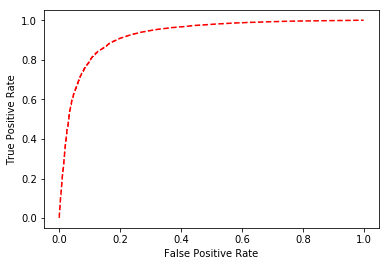

In [40]:
from sklearn.metrics import roc_auc_score ,roc_curve
y_pred = model.predict_proba(test_bows)[:,1]
fpr,tpr,thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [41]:
print(roc_auc_score(y_test,y_pred))

0.9253119043224388


[[ 4391   978]
 [ 2556 22075]]


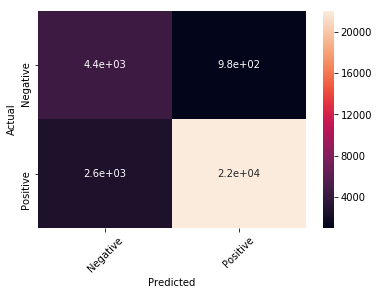

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(y_test , pred_test)
print(confusion)
df_cm = pd.DataFrame(confusion , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Observation:
LR on BOW with L1
Optimal C= 1
AUC= 0.9253119043224388
f1= 0.9258870900092273
precision on positive = 0.96
predcision on negative = 0.63
recall on positive = 0.90
recall on negative = 0.82


In [65]:
clf1 = LogisticRegression(penalty = 'l1', C = 1,class_weight = 'balanced')
clf1.fit(Train_bows, y_Train)
pred = clf1.predict(test_bows)
pred_train= clf1.predict(Train_bows)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_Train,pred_train)

In [66]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)

Error on test 11.776666666666669
Error on train 6.687142857142858


Accuracy on test set: 0.882%
Precision on test set: 0.958
Recall on test set: 0.896
F1-Score on test set: 0.926
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



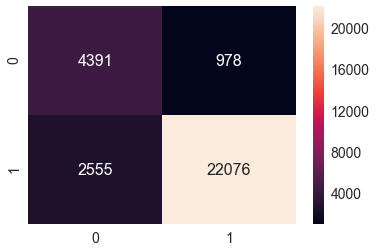

In [67]:
from sklearn.metrics import recall_score , precision_score, f1_score
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [70]:
w1 = clf1.coef_
print('Sparsity',np.count_nonzero(w1)-len(w1))

Sparsity 5126


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [57]:
clf = LogisticRegression(penalty = 'l1', C = 0.1,class_weight = 'balanced')
clf.fit(Train_bows, y_Train)
pred = clf.predict(test_bows)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
w= clf.coef_
print("Sparsity:",np.count_nonzero(w)-len(w))

Accuracy on test set: 86.713%
F1-Score on test set: 0.915
Sparsity: 1285


In [58]:
clf = LogisticRegression(penalty = 'l1', C = 1,class_weight = 'balanced')
clf.fit(Train_bows, y_Train)
pred = clf.predict(test_bows)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
w= clf.coef_
print("Sparsity:",np.count_nonzero(w)-len(w))

Accuracy on test set: 88.220%
F1-Score on test set: 0.926
Sparsity: 5123


In [59]:
clf = LogisticRegression(penalty = 'l1', C = 10,class_weight = 'balanced')
clf.fit(Train_bows, y_Train)
pred = clf.predict(test_bows)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
w= clf.coef_
print("Sparsity:",np.count_nonzero(w)-len(w))

Accuracy on test set: 87.213%
F1-Score on test set: 0.920
Sparsity: 10253


In [60]:
clf = LogisticRegression(penalty = 'l1', C = 100,class_weight = 'balanced')
clf.fit(Train_bows, y_Train)
pred = clf.predict(test_bows)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
w= clf.coef_
print("Sparsity:",np.count_nonzero(w)-len(w))

Accuracy on test set: 84.807%
F1-Score on test set: 0.906
Sparsity: 12854


In [61]:
clf = LogisticRegression(penalty = 'l1', C = 1000,class_weight = 'balanced')
clf.fit(Train_bows, y_Train)
pred = clf.predict(test_bows)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
w= clf.coef_
print("Sparsity:",np.count_nonzero(w)-len(w))

Accuracy on test set: 83.897%
F1-Score on test set: 0.900
Sparsity: 14346


As C increases sparsity also increases. at c= 0.1 sparsity =1285 and at c=1000 sparsity= 14,346

#### [5.1.1.2] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [74]:
rand = np.random.normal(loc = 0,scale = 0.01, size = 1)
Train_bows.data = Train_bows.data + rand

In [75]:
clf_noise = LogisticRegression(class_weight = 'balanced',C = 1)
clf_noise.fit(Train_bows,y_Train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [76]:
w_noise = clf_noise.coef_
print(w_noise)

[[ 1.54644499e-03 -3.96214186e-06 -3.96214186e-06 ...  2.66382559e-04
   5.08159609e-02  5.28235270e-03]]


In [77]:
per =((w_noise[0] - w1[0])/abs(w1[0]))
per = abs(per)
len_per = len(per)
change = []
for i in per:
    if i > 0.3:
         change.append(i)
len_change = len(change)

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [78]:
print(len_per)
print(len_change)
print('Multicollinearity exists in features for change greater than 30% is',(len_change/len_per)*100,'%')

31732
28939
Multicollinearity exists in features for change greater than 30% is 91.19815958653726 %


In [79]:
change = []
for i in per:
    if i > 0.4:
         change.append(i)
len_change = len(change)

In [80]:
print(len_per)
print(len_change)
print('Multicollinearity exists in features for change greater than 40% is',(len_change/len_per)*100,'%')

31732
28512
Multicollinearity exists in features for change greater than 40% is 89.8525148115467 %


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [89]:
tuned_param = [{'C' : [10** -4, 10**-3,10**-2,10**-1,1,10,100,1000,10000]}]
model  =GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty='l2'),tuned_param , scoring = 'f1',cv = 5, n_jobs= -1)
model.fit(Train_bi_gram,y_Train)
print(model.best_estimator_)
print(model.score(test_bi_gram, y_test))

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9265589305355784


In [90]:
pred_test_l2 = model.predict(test_bi_gram)

In [91]:
print(classification_report(y_test,pred_test_l2))

             precision    recall  f1-score   support

          0       0.63      0.86      0.73      5369
          1       0.97      0.89      0.93     24631

avg / total       0.91      0.88      0.89     30000



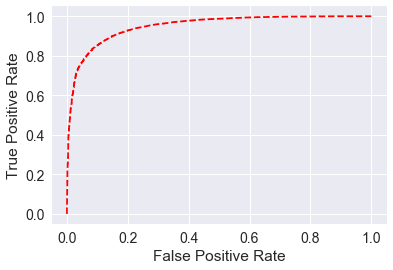

In [92]:
y_pred_l2 = model.predict_proba(test_bi_gram)[:,1]
fpr,tpr,thresholds = roc_curve(y_test, y_pred_l2)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [93]:
print(roc_auc_score(y_test,y_pred_l2))

0.9491130282447412


[[ 4626   743]
 [ 2729 21902]]


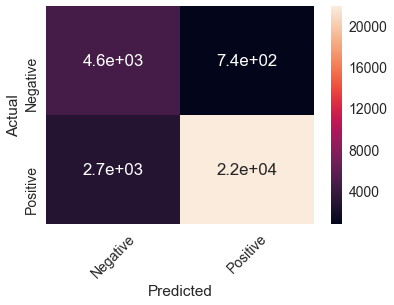

In [94]:
confusion_l2 = confusion_matrix(y_test , pred_test_l2)
print(confusion_l2)
df_cm = pd.DataFrame(confusion_l2 , index = ['Negative','Positive'])
sns.heatmap(df_cm ,annot = True)
plt.xticks([0.5,1.5],['Negative','Positive'],rotation = 45)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [95]:
clf_l2 = LogisticRegression(C = 10 , penalty = 'l2', class_weight = 'balanced')
clf_l2.fit(Train_bi_gram, y_Train)
pred_l2 = clf_l2.predict(test_bi_gram)
pred_train_l2 = clf_l2.predict(Train_bi_gram)
test_error = 1-accuracy_score(y_test,pred_l2)
train_error = 1-accuracy_score(y_Train,pred_train_l2)

In [96]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)

Error on test 11.573333333333336
Error on train 8.274285714285712


Accuracy on test set: 0.884%
Precision on test set: 0.967
Recall on test set: 0.889
F1-Score on test set: 0.927
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



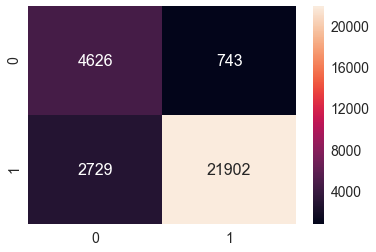

In [101]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred_l2)))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred_l2)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred_l2)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred_l2)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred_l2), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [102]:
w_l2 = clf1.coef_
print('Sparsity',np.count_nonzero(w_l2)-len(w_l2))

Sparsity 5126


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class and negative class from<font color='red'> SET 1</font>

In [86]:
uni_gram = CountVectorizer()
def show_most_informative_features(vectorizer, clf1, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf1.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\tPositive\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))


show_most_informative_features(count_vectorizer,clf1)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

		Positive					Negative
________________________________________________________________________________________________
	-10.4165	toot           				5.3111	biggi          
	-8.9716	gbs            				5.0595	yay            
	-8.1687	context        				4.6155	tornado        
	-7.1236	avert          				4.3188	iprozon        
	-7.0895	sopaipilla     				4.3035	convert        
	-6.6200	mozzerela      				4.1188	durachew       
	-6.4391	absoprt        				3.9788	skeptic        
	-6.1674	eng            				3.8866	muir           
	-5.8090	unforun        				3.8532	expel          
	-5.7273	doenst         				3.7841	inhal          


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [107]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean = False)
X_tr = sc.fit_transform(tfidf_train)
X_te = sc.transform(tfidf_test)
param = [{'C':[10**i for i in range(-3,4)]}]
gd = GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty = 'l1'),param,cv = 5, scoring = 'f1',n_jobs = -1)
gd.fit(X_tr,y_Train)
print(gd.best_estimator_)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [108]:
X_tr.shape

(70000, 41985)

In [109]:
X_te.shape

(30000, 41985)

In [110]:
print(gd.score(X_te, y_test))

0.9376276448002615


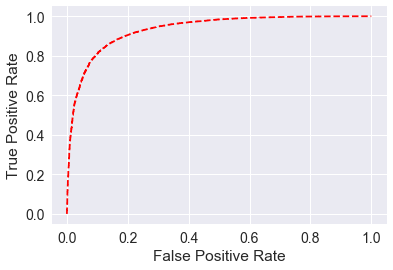

In [119]:
from sklearn.metrics import roc_auc_score ,roc_curve
y_pred = gd.predict_proba(X_te)[:,1]
fpr,tpr,thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [120]:
print(roc_auc_score(y_test,y_pred))

0.9335077795193166


In [121]:
clf = LogisticRegression(penalty = 'l1', C = 0.1,class_weight = 'balanced')
clf.fit(X_tr, y_Train)
pred = clf.predict(X_te)
pred_train= clf.predict(X_tr)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_Train,pred_train)

In [122]:
print("train error is:\t",train_error)
print("test error is:\t",test_error)

train error is:	 0.00014285714285711126
test error is:	 0.10183333333333333


Accuracy on test set: 0.898%
Precision on test set: 0.943
Recall on test set: 0.932
F1-Score on test set: 0.938
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



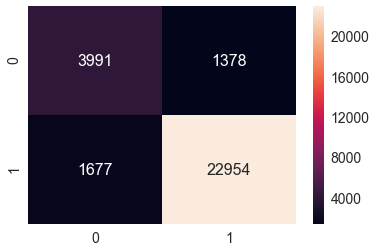

In [123]:
from sklearn.metrics import recall_score , precision_score, f1_score
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [125]:
w = clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Sparsity 13873


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [118]:
tuned_param = [{'C' : [10** -4, 10**-3,10**-2,10**-1,1,10,100,1000,10000]}]
model  =GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty='l2'),tuned_param , scoring = 'f1',cv = 5, n_jobs= -1)
model.fit(X_tr,y_Train)
print(model.best_estimator_)
print(model.score(X_te, y_test))

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.9408115048793015


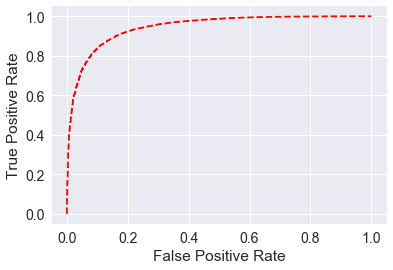

In [138]:
y_pred1 = model.predict_proba(X_te)[:,1]
fpr,tpr,thresholds = roc_curve(y_test, y_pred1)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [139]:
print(roc_auc_score(y_test, y_pred1))

0.9438785008351127


In [140]:
clf = LogisticRegression(penalty = 'l2', C = 0.0001,class_weight = 'balanced')
clf.fit(X_tr, y_Train)
pred = clf.predict(X_te)
pred_train= clf.predict(X_tr)
test_error = 1-accuracy_score(y_test,pred)
train_error = 1-accuracy_score(y_Train,pred_train)

In [141]:
print("train error:\t",train_error)
print("test error:\t",test_error)

train error:	 0.019614285714285695
test error:	 0.0960333333333333


Accuracy on test set: 0.904%
Precision on test set: 0.952
Recall on test set: 0.930
F1-Score on test set: 0.941
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



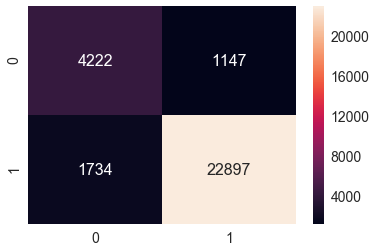

In [142]:
from sklearn.metrics import recall_score , precision_score, f1_score
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

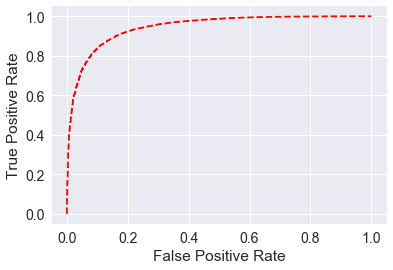

In [146]:
y_pred = clf.predict_proba(X_te)[:,1]
fpr,tpr,thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [147]:
print(roc_auc_score(y_test,y_pred))

0.9438785008351127


In [148]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.71      0.79      0.75      5369
          1       0.95      0.93      0.94     24631

avg / total       0.91      0.90      0.91     30000



In [149]:
w = clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

Sparsity 41984


### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of Negative and  positive class from<font color='red'> SET 2</font>

In [150]:
def show_most_informative_features(vectorizer, clf, n=10):    
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\tNegative\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))


show_most_informative_features(tfidf_vect,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

		Negative					Positive
________________________________________________________________________________________________
	-0.0983	disappoint     				0.1128	great          
	-0.0644	worst          				0.0973	love           
	-0.0601	aw             				0.0818	best           
	-0.0600	return         				0.0713	delici         
	-0.0597	terribl        				0.0670	good           
	-0.0535	horribl        				0.0614	perfect        
	-0.0512	bland          				0.0570	excel          
	-0.0502	unfortun       				0.0518	favorit        
	-0.0492	wast money     				0.0499	high recommend 
	-0.0482	wont buy       				0.0485	nice           


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [184]:
param = [{'C':[10**i for i in range(-3,4)]}]
w2v_model = GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty = 'l1'),param,scoring = 'f1',cv = 5,n_jobs = -1,)
w2v_model.fit(w2v_train,y_Train)
print(w2v_model.best_estimator_)
#pred = w2v_model.predict(w2v_test)
print(w2v_model.score(w2v_test, y_test))

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8892719001142354


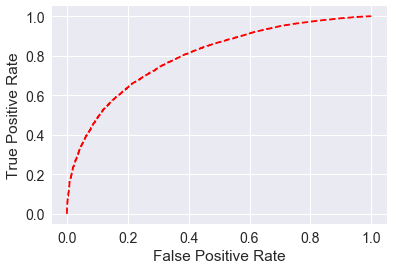

In [186]:
y_pred = w2v_model.predict_proba(w2v_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [187]:
print(roc_auc_score(y_test,y_pred))

0.7976084125930434


In [188]:
clf = LogisticRegression(penalty = 'l1', C = 1,class_weight = 'balanced')
clf.fit(w2v_train,y_Train)
pred_test = clf.predict(w2v_test)
pred_train = clf.predict(w2v_train)
test_error = 1-accuracy_score(y_test,pred_test)
train_error = 1-accuracy_score(y_Train,pred_train)

In [189]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)

Error on test 18.41666666666667
Error on train 18.377142857142857


In [190]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.48      0.43      0.45      5369
          1       0.88      0.90      0.89     24631

avg / total       0.81      0.82      0.81     30000



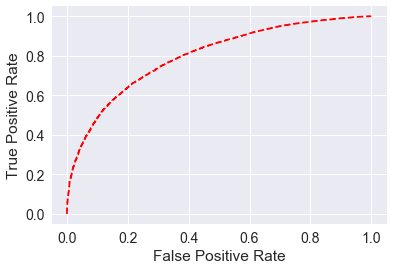

In [191]:
y_pred1 = clf.predict_proba(w2v_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test, y_pred1)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [192]:
print(roc_auc_score(y_test,y_pred1))

0.7976048131815048


### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [200]:
tuned_param = [{'C':[10**i for i in range(-3,4)]}]
model = GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty = 'l2'),tuned_param,scoring = 'f1',cv = 5,n_jobs = -1,)
model.fit(w2v_train,y_Train)
print(model.best_estimator_)
print(model.score(w2v_test, y_test))

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8896187119512976


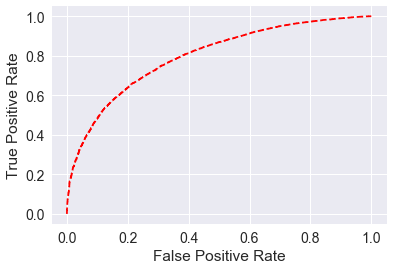

In [201]:
y_pred5 = model.predict_proba(w2v_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test, y_pred5)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [202]:
print("auc=",roc_auc_score(y_test,y_pred5))

auc= 0.7975573402704983


In [203]:
clf = LogisticRegression(penalty = 'l2', C = 10,class_weight = 'balanced')
clf.fit(w2v_train,y_Train)
pred_test = clf.predict(w2v_test)
pred_train = clf.predict(w2v_train)
test_error = 1-accuracy_score(y_test,pred_test)
train_error = 1-accuracy_score(y_Train,pred_train)

In [204]:
print('Error on test',test_error*100)
print('Error on train',train_error*100)

Error on test 18.37333333333333
Error on train 18.365714285714287


In [205]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.48      0.42      0.45      5369
          1       0.88      0.90      0.89     24631

avg / total       0.81      0.82      0.81     30000



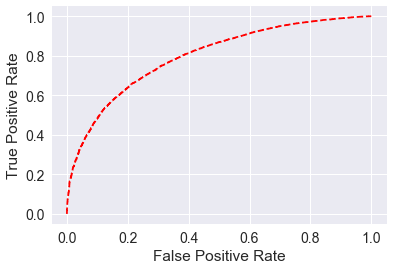

In [206]:
y_pred = clf.predict_proba(w2v_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [207]:
print(roc_auc_score(y_test, y_pred))

0.7975573402704983


## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [48]:
param = [{'C':[10**i for i in range(-3,4)]}]
wv_model = GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty = 'l1'),param,scoring = 'f1',cv = 5,n_jobs = -1,)
wv_model.fit(tfidf_w2v_train,y_Train)
print(wv_model.best_estimator_)
print(wv_model.score(tfidf_w2v_test, y_test))

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.8332728427547409


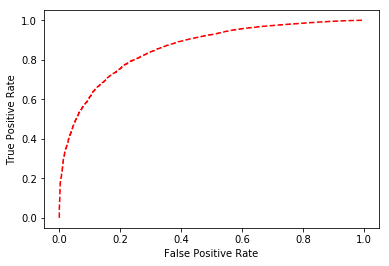

In [51]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred = wv_model.predict_proba(tfidf_w2v_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [52]:
roc_auc_score(y_test, y_pred)

0.8600268865532044

In [54]:
clf = LogisticRegression(penalty = 'l1', C = 1,class_weight = 'balanced')
clf.fit(tfidf_w2v_train, y_Train)
pred_test = clf.predict(tfidf_w2v_test)
pred_train = clf.predict(tfidf_w2v_train)
test_error = 1-accuracy_score(y_test,pred_test)
train_error = 1-accuracy_score(y_Train,pred_train)

In [56]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.40      0.81      0.54      5290
          1       0.95      0.74      0.83     24710

avg / total       0.85      0.76      0.78     30000



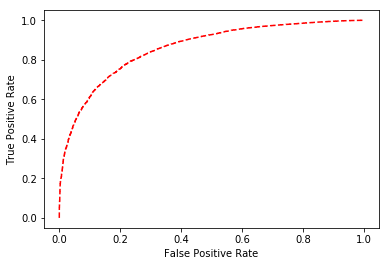

In [57]:
y_pred = clf.predict_proba(tfidf_w2v_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [59]:
roc_auc_score(y_test, y_pred)

0.8600269324542767

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [60]:
param = [{'C':[10**i for i in range(-3,4)]}]
wv_model = GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty = 'l2'),param,scoring = 'f1',cv = 5,n_jobs = -1,)
wv_model.fit(tfidf_w2v_train,y_Train)
print(wv_model.best_estimator_)
print(wv_model.score(tfidf_w2v_test, y_test))

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.833390041964387


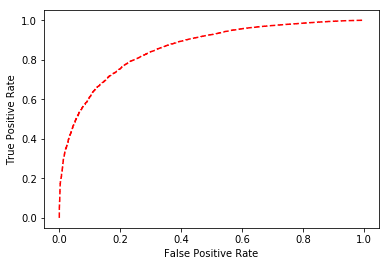

In [61]:
y_pred = wv_model.predict_proba(tfidf_w2v_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [62]:
roc_auc_score(y_test, y_pred)

0.860028523691456

In [63]:
clf = LogisticRegression(penalty = 'l2', C = 10,class_weight = 'balanced')
clf.fit(tfidf_w2v_train, y_Train)
pred_test = clf.predict(tfidf_w2v_test)
pred_train = clf.predict(tfidf_w2v_train)
test_error = 1-accuracy_score(y_test,pred_test)
train_error = 1-accuracy_score(y_Train,pred_train)

In [64]:
print(classification_report(y_test,pred_test))

             precision    recall  f1-score   support

          0       0.40      0.81      0.54      5290
          1       0.95      0.74      0.83     24710

avg / total       0.85      0.76      0.78     30000



Accuracy on test set: 0.755%
Precision on test set: 0.948
Recall on test set: 0.743
F1-Score on test set: 0.833
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



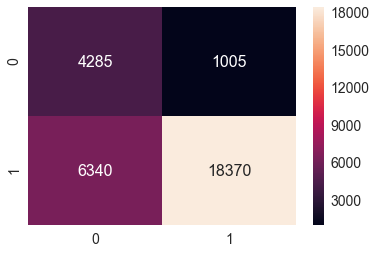

In [68]:
from sklearn.metrics import recall_score , precision_score, f1_score, confusion_matrix
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred_test)))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred_test)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred_test)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred_test)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred_test), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

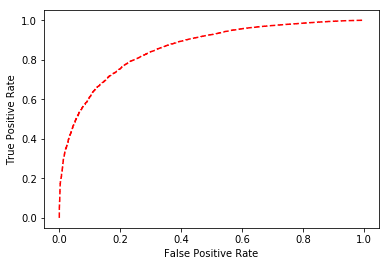

In [65]:
y_pred = clf.predict_proba(tfidf_w2v_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr,tpr,'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [66]:
roc_auc_score(y_test, y_pred)

0.860028523691456

# [6] Conclusions

Observations:
From above all observation, as we see all measure metrices, tfidf with l2 regularizer gives better insights comparatively.